In [14]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '300 200 120 80 30'
environ['dropouts'] = '0.3 0.2 0.2 0.1 0.1'
environ['log'] = 'True'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'

%run utils.ipynb

In [15]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


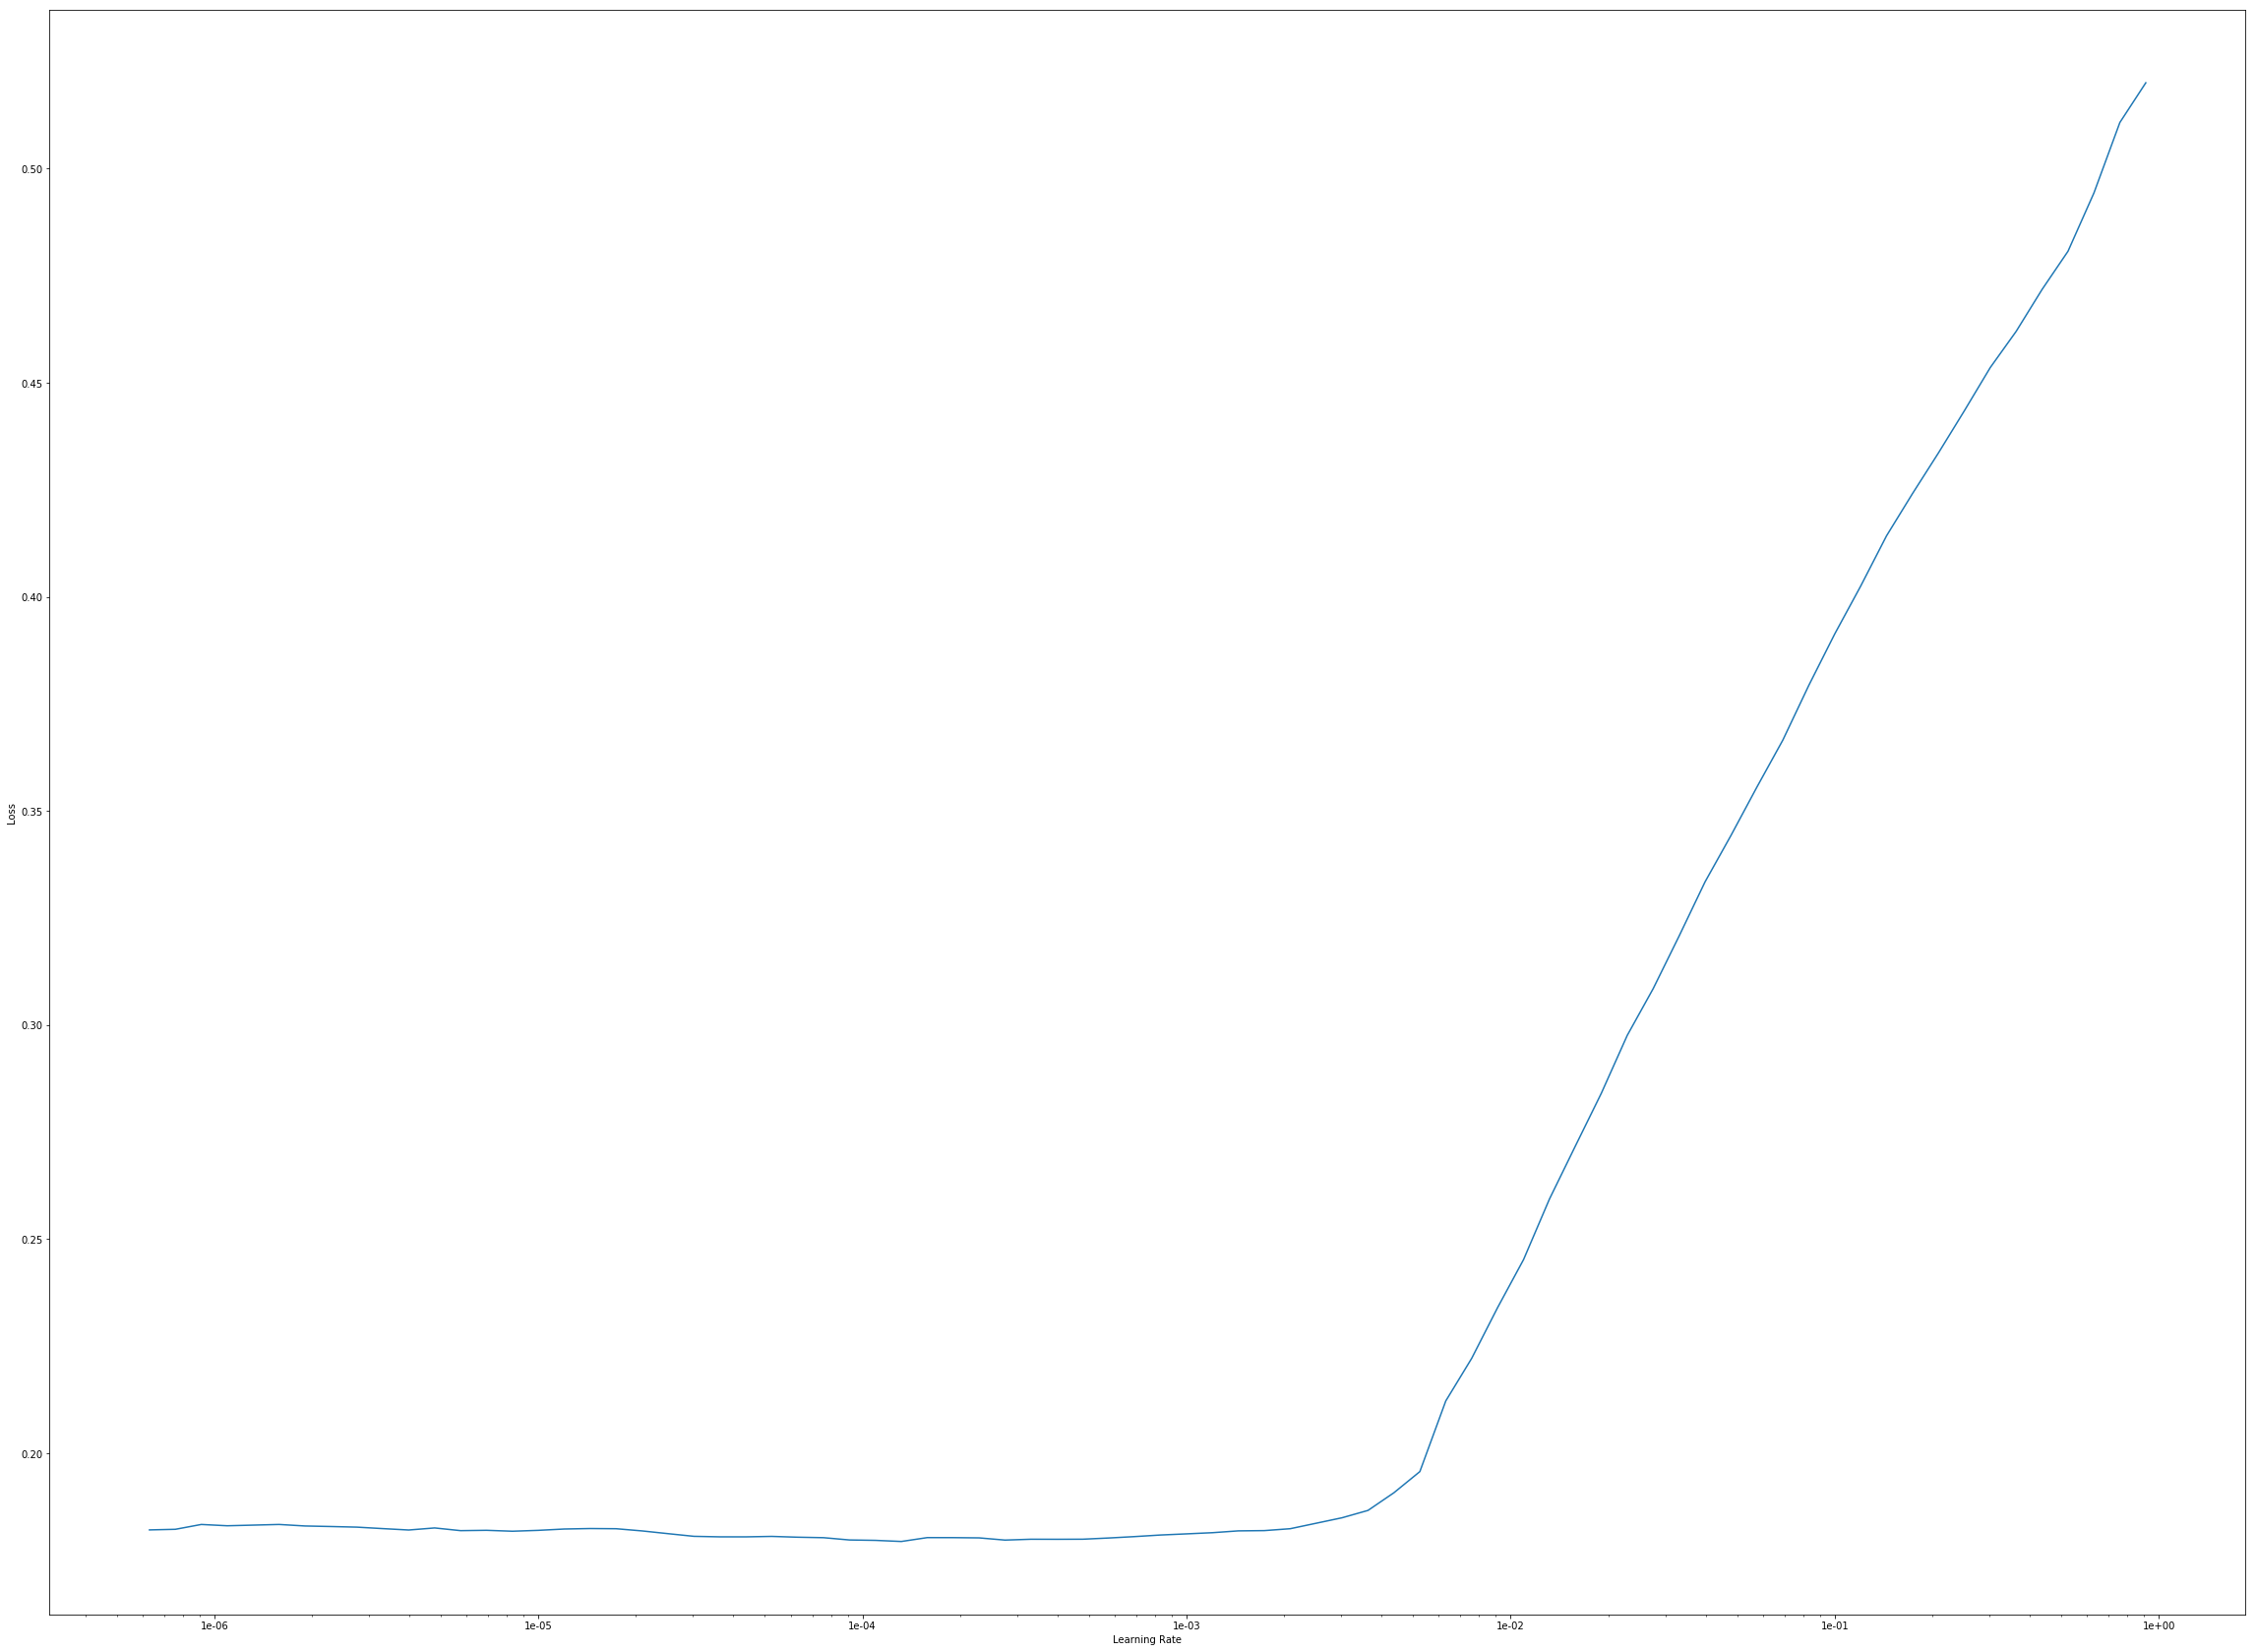

In [8]:
l.recorder.plot()

In [27]:
lr = 1e-05

In [28]:
l.model.train()
l.fit_one_cycle(200, lr)

epoch,train_loss,valid_loss
1,0.175457,0.202847
2,0.175187,0.201173
3,0.175233,0.201433
4,0.175345,0.206690
5,0.175418,0.199320
6,0.175091,0.203579
7,0.175121,0.200019
8,0.175662,0.203850
9,0.175535,0.201097
10,0.175672,0.201775


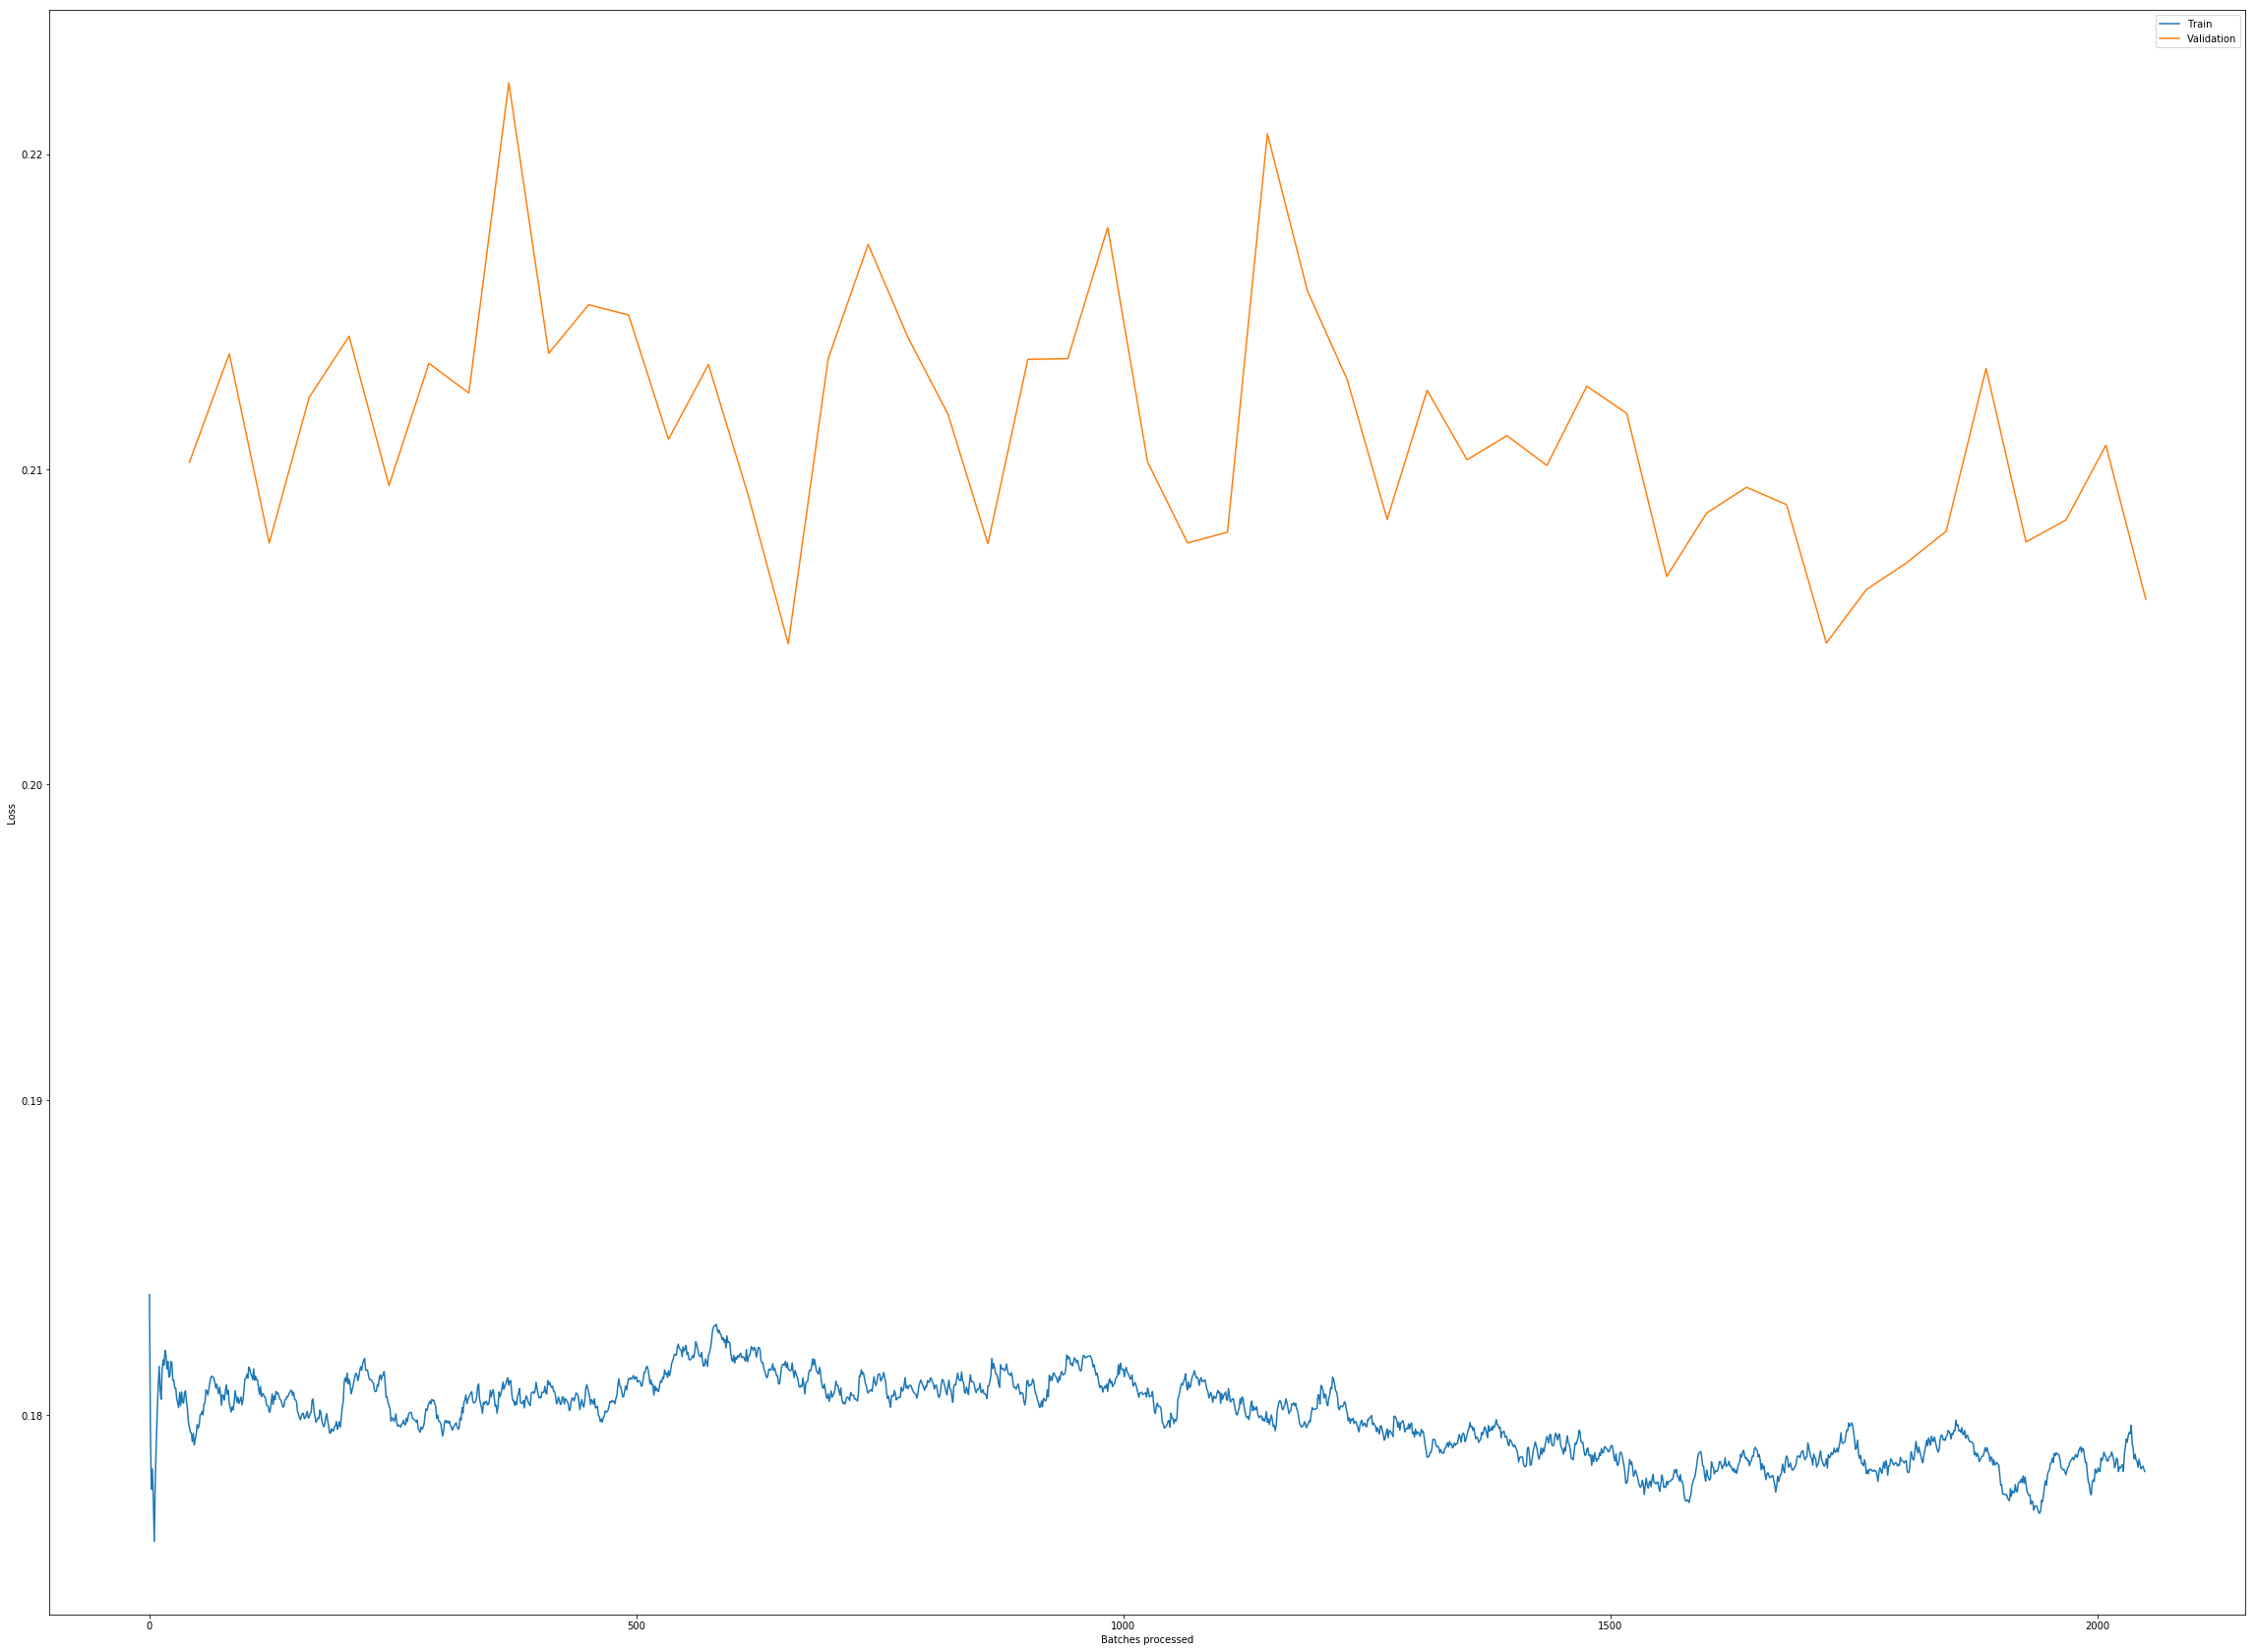

In [12]:
l.recorder.plot_losses()

In [ ]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [29]:
val_df = get_results_df(val_dl, l.model, log=log)
train_df = get_results_df(train_dl, l.model, log=log)

In [30]:
df = val_df

In [31]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.707597,2.000809,0.606929,40.383030
std,1.362896,1.976999,0.965663,59.006836
min,0.073060,0.031768,0.000147,0.012045
25%,0.688612,0.654077,0.102342,11.597545
50%,1.332959,1.387794,0.299076,24.896612
75%,2.300447,2.403782,0.669563,45.291461
max,5.839882,12.500638,9.436485,778.541565


In [23]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,657.000000,657.000000,657.000000,657.000000
mean,3.948848,5.115778,1.365126,29.287535
std,1.486039,2.790569,1.714994,38.937504
min,0.398863,0.105179,0.003013,0.206864
25%,2.479949,2.706949,0.270402,8.261179
50%,4.648192,5.420588,0.649103,21.397005
75%,4.834735,6.326712,1.784681,33.637047
max,5.690990,12.500638,7.442226,280.300598


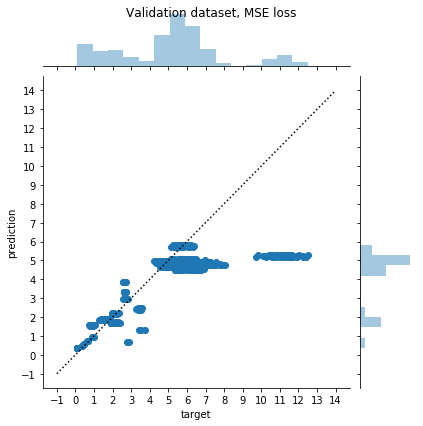

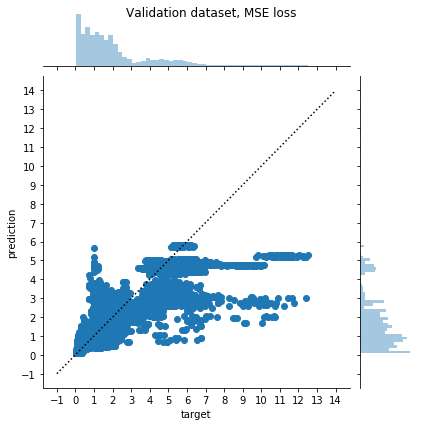

In [32]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")